## Exporting the results to PDF

Once you complete the assignments, export the entire notebook as PDF and attach it to your homework solutions. 
The best way of doing that is
1. Run all the cells of the notebook.
2. Export/download the notebook as PDF (File -> Download as -> PDF via LaTeX (.pdf)).
3. Concatenate your solutions for other tasks with the output of Step 2. On linux, you can use `pdfunite`, there are similar tools for other platforms, too. You can only upload a single PDF file to Moodle.

Make sure you are using `nbconvert` version 5.5 or later by running `jupyter nbconvert --version`. Older versions clip lines that exceed page width, which makes your code harder to grade.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.datasets import load_sample_image

%matplotlib inline

def compare_images(img, img_compressed, k):
    """Show the compressed and uncompressed image side by side.
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 12))
    axes[0].set_axis_off()
    if isinstance(k, str):
        axes[0].set_title(k)
    else:
        axes[0].set_title(f"Compressed to {k} colors")
    axes[0].imshow(img_compressed)
    axes[1].set_axis_off()
    axes[1].set_title("Original")
    axes[1].imshow(img)


# K-Means

In this first section you will implement the image compression algorithm from Bishop, chapter 9.1.1. Take an RGB image $X \in \mathbb{R}^{h \times w \times 3}$ and interpret it as a data matrix $X \in \mathbb{R}^{N \times 3}$. Now apply $k$-means clustering to find $k$ colors that describe the image well and replace each pixel with its associated cluster.

In [2]:
# Alternatively try china.jpg
X = load_sample_image("flower.jpg")

# or load your own image
# X = np.array(Image.open("/home/user/path/to/some.jpg"))



In [3]:
def kmeans(X, k):
    """Compute a k-means clustering for the data X.
    
    Parameters
    ----------
    X : np.array of size N x D
        where N is the number of samples and D is the data dimensionality
    k : int
        Number of clusters
        
    Returns
    -------
    mu : np.array of size k x D
        Cluster centers
    z : np.array of size N
        Cluster indicators, i.e. a number in 0..k - 1, for each data point in X
    """
    
    # TODO: Compute mu and z
    
    #Initialize centroids 
    initial_mu = np.random.randint(0, 10, (k, 3), dtype=np.uint8)
    #print(X.shape)
    new_centroids=np.empty((k,3))
    old_centroids=np.empty((k,3))
    N= X.shape[0]
    euclidean_distance = np.empty((5))
    z= np.empty(N)
    while not np.array_equal(new_centroids, old_centroids):
        old_centroids= new_centroids.copy()
        z= np.empty(N)
        for i in range(N):
            for j in range(k):
                euclidean_distance[j] = np.linalg.norm(X[i] -initial_mu[j] )
            #print(euclidean_distance)    
            min_distance = np.min(euclidean_distance, axis=0)
            #print(min_distance)
            min_distance_index = np.argwhere(euclidean_distance == min_distance)
            #print(min_distance_index[0])
            z[i]= min_distance_index[0]
            euclidean_distance = np.empty((5))
            
        new_centroids=np.empty((k,3))
        #calculate new centroids
        for i in range(k) :
            one_hot_encoding = (z == i).astype(int).reshape(N, 1)
            points_of_interest = X*one_hot_encoding
            col_sum = np.sum(points_of_interest, axis=0)
            zero_rows = np.count_nonzero(np.all(points_of_interest == 0, axis=1))
            num_data_points_in_cluster= N-zero_rows
            new_centroids[i,:] = np.where(num_data_points_in_cluster == 0, 0, col_sum / num_data_points_in_cluster)
            
        
    
   
    return new_centroids,z



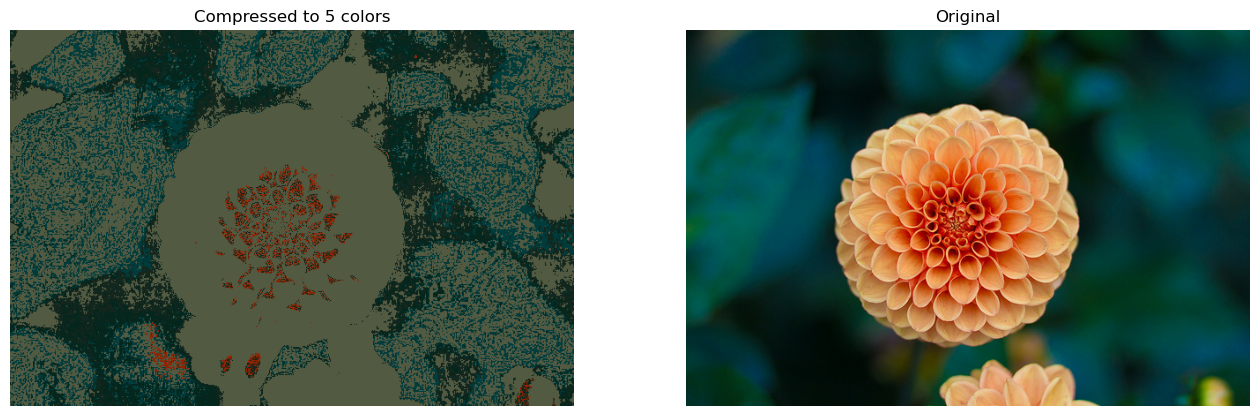

In [4]:
# Cluster the color values
k = 5
mu, z = kmeans(X.reshape((-1, 3)), k)
z = z.astype(int)
#print(mu)
#print(z)
# Replace each pixel with its cluster color
X_compressed = mu[z].reshape(X.shape).astype(np.uint8)

# Show the images side by side
compare_images(X, X_compressed, k)

# Gaussian Mixture Models & EM

Now you will repeat the same exercise with GMMs.

In [5]:
def gaussian_log_pdf(X, mu, sigma):
    """Compute log probability density function of a Gaussian distribution.
    
    Parameters
    ----------
    X : np.array of shape (N, D)
        Data points.
    mu : np.array of shape (D,)
        Mean vector.
    sigma : np.array of shape (D, D)
        Covariance matrix.
    
    Returns
    -------
    log_pdf : np.array of shape (N,)
        Log probability densities of each data point under the Gaussian.
    """
    D = X.shape[1]
    #print(X.shape)
    #print(mu.shape)
    #print(sigma.shape)
    
    sigma_inv = np.linalg.inv(sigma)
    sigma_det = np.linalg.det(sigma)
    
    
    A = X - mu
    B = np.einsum('ij,jk,ik->i', A, sigma_inv, A)
    
    
    log_pdf = -0.5 * (D * np.log(2 * np.pi) + np.log(sigma_det) + B)
    return log_pdf 




In [6]:

def gmm_log_probability(X, pi, mu, sigma):
    """Compute the joint log-probabilities for each data point and component.
    
    Parameters
    ----------
    X : np.array of shape (N, D)
        Data points.
    pi : np.array of shape (K,)
        Prior weight of each component.
    mu : np.array of shape (K, D)
        Mean vectors of the K Gaussian component distributions.
    sigma : np.array of shape (K, D, D)
        Covariance matrices of the K Gaussian component distributions.
    
    Returns
    -------
    log_P : np.array of shape (N, K)
        log_P[i, j] is the joint log-probability of data point i under component j.
    """
    N, D = X.shape
    K = pi.shape[0]
    
    
    log_P = np.zeros((N, K))
    
    for k in range(K):
        log_P[:, k] = np.log(pi[k]+ 1e-8) + gaussian_log_pdf(X, mu[k], sigma[k])
    return log_P
    

In [7]:
 


def em(X, k, tol=0.001, max_iters=100):
    """Fit a Gaussian mixture model with k components to X using the EM algorithm.
    
    Parameters
    ----------
    X : np.array of shape (N, D)
        where N is the number of samples and D is the data dimensionality.
    k : int
        Number of clusters (Gaussian components).
    tol : float
        Converge when the increase in the mean of the expected joint log-likelihood
        is lower than this.
    max_iters : int
        Maximum number of iterations.
    
    Returns
    -------
    pi : np.array of shape (k,)
        Prior weight of each component.
    mu : np.array of shape (k, D)
        Mean vectors of the k Gaussian component distributions.
    sigma : np.array of shape (k, D, D)
        Covariance matrices of the k Gaussian component distributions.
    """
    
    N, D = X.shape
    np.random.seed(42)
    mu = X[np.random.choice(N, k, replace=False)]
    sigma = np.array([np.eye(D) for _ in range(k)])
    pi = np.ones(k) / k
    log_likelihoods = []
    
    for iteration in range(max_iters):
        # E-step
        log_probs = gmm_log_probability(X, pi, mu, sigma)  
        log_probs += np.log(pi)  
        log_probs_max = np.max(log_probs, axis=1, keepdims=True)  
        probs = np.exp(log_probs - log_probs_max)  
        gamma = probs / np.sum(probs, axis=1, keepdims=True)  
        
        # M-step
        N_k = gamma.sum(axis=0)  # number of points in each cluster
        pi = N_k / N           
        mu = (gamma.T @ X) / (N_k[:, np.newaxis] + 1e-8) #update centorids       
        # Update covariance matrices
        for j in range(k):
            A = X - mu[j]
            sigma[j] = (gamma[:, j][:, np.newaxis] * A).T @ A / N_k[j]
            sigma[j] += np.eye(D) * 1e-6  
        
        # cobvergence check
        log_probs = gmm_log_probability(X, pi, mu, sigma)  
        likelihoods = np.exp(log_probs) @ pi  
        log_likelihood = np.sum(np.log(likelihoods))  

        log_likelihoods.append(log_likelihood)  

        if iteration > 0 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            print(f"Converged in {iteration} iterations")  
            break  


    return pi, mu, sigma


Converged in 36 iterations


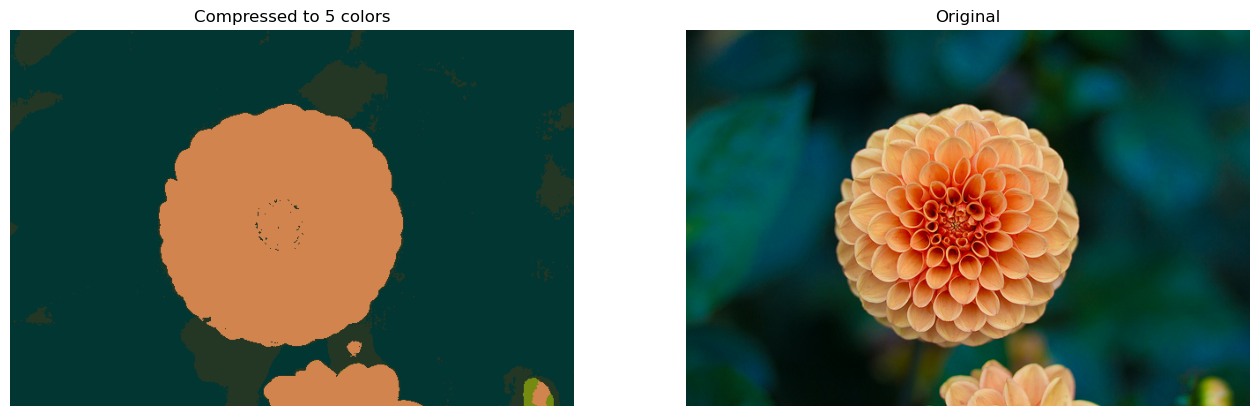

In [9]:
# Fit the GMM
k = 5
pi, mu, sigma = em(X.reshape((-1, 3)), k)

# Determine the most likely cluster of each pixel
log_p = gmm_log_probability(X.reshape((-1, 3)), pi, mu, sigma)
z = log_p.argmax(axis=1)

# Replace each pixel with its cluster mean
X_compressed = mu[z].reshape(X.shape).astype(np.uint8)

# Show the images side by side
compare_images(X, X_compressed, k)

# Sampling Unseen Datapoints

You have trained a generative model which allows you to sample from the learned distribution. In this section, you sample new images.

In [14]:
def gmm_sample(N, pi, mu, sigma):
    """Sample N data points from a Gaussian mixture model.
    
    Parameters
    ----------
    N : int
        Number of data points to sample
    pi : np.array of size k
        Prior weight of each component
    mu : np.array of size k x D
        Mean vectors of the k Gaussian component distributions
    sigma : np.array of size k x D x D
        Covariance matrices of the k Gaussian component distributions
    
    Returns
    -------
    X : np.array of shape N x D
    """
    
    # TODO: Sample X
    k, D = mu.shape
    X = np.zeros((N, D))  
    labels = np.zeros(N, dtype=int)  

    labels = np.random.choice(k, size=N, p=pi)  

    for i in range(k):
        num_samples = np.sum(labels == i)  
        if num_samples > 0:
            X[labels == i] = np.random.multivariate_normal(mu[i], sigma[i], size=num_samples)
            
    return X

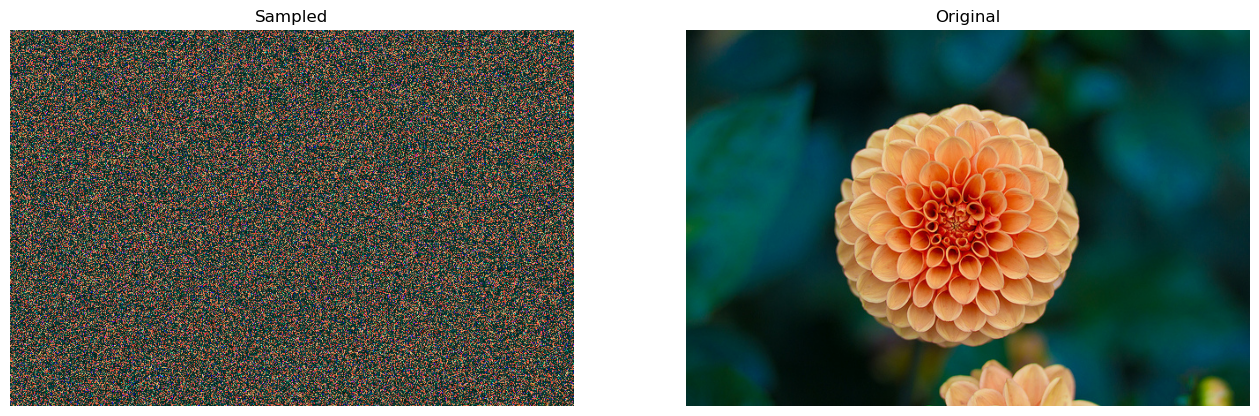

In [15]:
# Sample pixels and reshape them into the size of the original image
X_sampled = gmm_sample(np.prod(X.shape[:-1]), pi, mu, sigma).reshape(X.shape).astype(np.uint8)

# Compare the original and the sampled image
compare_images(X, X_sampled, "Sampled")

Explain what you see in the generated images. (1-3 sentences)
-The reuslts from the k-means algoritmn are not as uniform as the results from the gaussian mixture model.
-This is due to the fact that there is no hard assigment for GMM causing that colors similar to each other but not equal be grouped together.
